import pandas as pd
import pickle
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
# Imports

In [3]:
import folium
import networkx as nx
import dijkstar
from OR_tools_tsp_solution import *
from create_data_model_or import *
%matplotlib inline
import copy
import imageio
from PIL import Image

## My Data

In [4]:
stations_df = pd.read_csv("./saved_data/final_station_df.csv", index_col = 0)
non_unique_stations_df = pd.read_csv("./saved_data/non_unique_mta_stations.csv", index_col=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
my_edgelist = pd.read_csv('./saved_data/edge_list_df_no_req.csv', index_col=0)
node_list_df = pd.read_csv("./saved_data/nodelist_nyc_subway.csv", index_col=0).reset_index()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# distance matrix dict 
with open("./saved_data/Distance_matrix_as_dict.pickle", "rb") as f:
    nyc_dist_matrix_dict = pickle.load(f)

<IPython.core.display.Javascript object>

In [9]:
tsp_df = pd.read_csv("./saved_data/TSP_solutions_df.csv", index_col = 0)
tsp_df.sort_values(by='Time_hrs_no_return').head()

<IPython.core.display.Javascript object>

## Visualizing All Stations

In [13]:
g = nx.Graph()

In [14]:
for i, elrow in my_edgelist.iterrows():
    # g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())  # deprecated after NX 1.11
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())

In [15]:
for i, nlrow in node_list_df.iterrows():
    nx.set_node_attributes(g, {nlrow['station_id']:  nlrow[1:].to_dict()})  

In [16]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))
# list(g.nodes(data=True))[0:2] 

# of edges: 542
# of nodes: 444


In [17]:
node_positions_as_dict = {x[0]: x[1] for x in list(g.nodes(data=True))}
node_positions_final = {key: value for key, value in node_positions_as_dict.items()}

### Checking for stops without coords

In [21]:
# node_positions_final

In [19]:
node_positions = {node[0]: (node[1]['Y'], node[1]['X']) for node in list(g.nodes(data=True))}
# dict(list(node_positions.items())[0:5])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Graph Representation of NYC Subway Network')

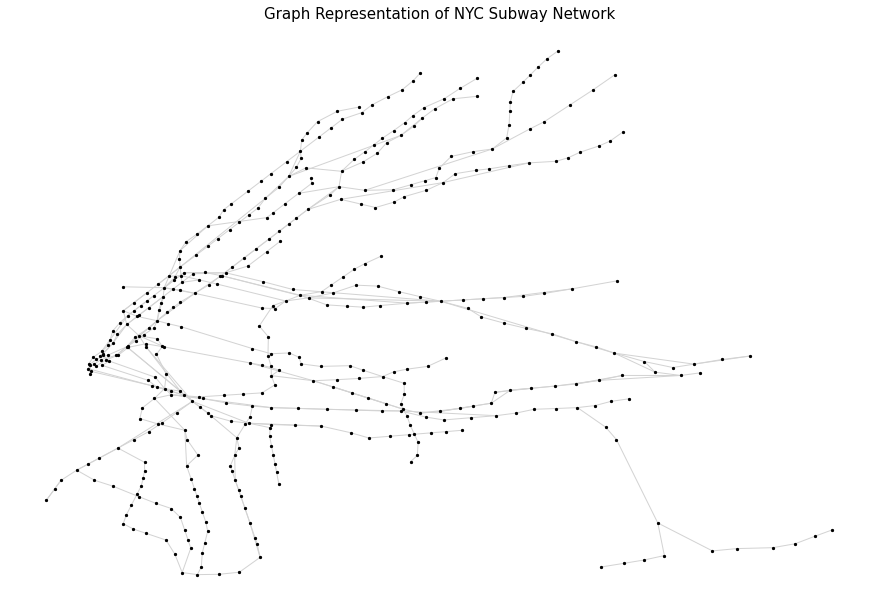

In [20]:
plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='black')
plt.title('Graph Representation of NYC Subway Network', size=15)
# plt.savefig("./saved_data/graph_of_nyc_stops.png", bbox_inches='tight')

# Plotting Stations 

In [22]:
base_map = folium.folium.Map([40.7128, -74.0061], zoom_start=10, tiles='cartodbpositron') # city hall coords

## Getting all coordinates for TSP_solutions_df

In [23]:
tsp_station_coords = []
for x in range(len(tsp_df)):
    station = tsp_df['Starting_station'][x]
    station_index = list(node_list_df['station_id']).index(station)
    station_coords = [node_list_df['X'][station_index], node_list_df['Y'][station_index]]
    tsp_station_coords.append(station_coords)

In [26]:
for idx, coord in enumerate(tsp_station_coords):
    if tsp_df['Time_hrs_no_return'][idx] < 19.5:
        folium.Circle(
            location = (coord[0], coord[1]),
            radius = 100, 
            popup = coord,
            color='green',
            fill=False,
        ).add_to(base_map)
    else:
        folium.Circle(
                location = (coord[0], coord[1]),
                radius = 100, 
                popup = coord,
                color='crimson',
                fill=False,
            ).add_to(base_map)

In [27]:
# looks like some of the outer stations work best
base_map

# Visualizing Route 

## Simplified Route Gif

### Getting h11_route

In [30]:
# this is simplified: it doesn't include intermediary steps between stations
h11_route = tsp_df['Station_id_route'][4]

In [60]:
h11_split = h11_route.split(", ")

In [76]:
new_h11 =[h11_split[0][2:-1]]

In [80]:
for x in h11_split[1:-1]:
    new_h11.append(x[1:-1])

In [86]:
new_h11.append(h11_split[-1][1:-2])

In [87]:
new_h11[-1]

'H11'

### Gif

In [100]:
g_i = nx.Graph(undirected=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(-74.04204765, -73.74175535000002, 40.5597771, 40.919474900000004)

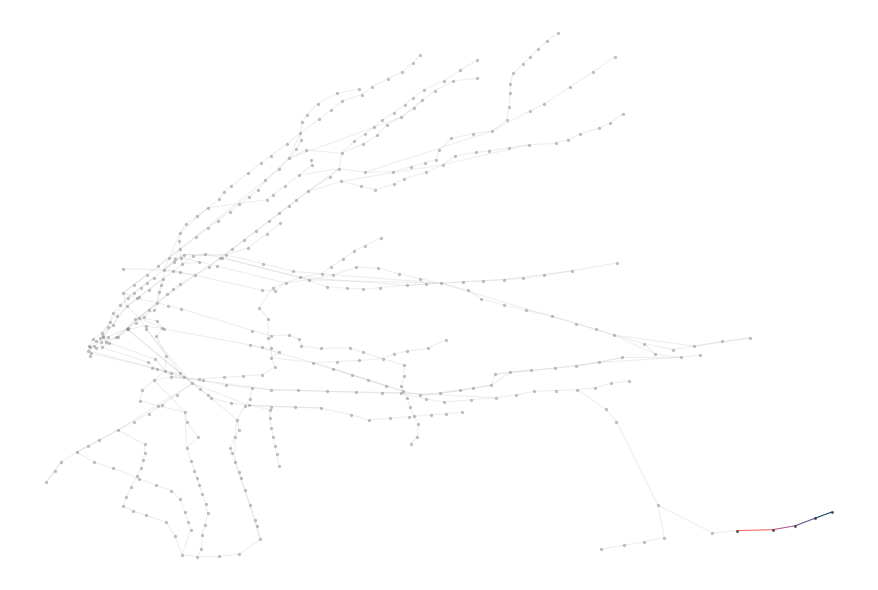

In [101]:
plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='gray', alpha=0.4)
g_i.add_edge(new_h11[0], new_h11[1])
g_i.add_edge(new_h11[1], new_h11[2])
g_i.add_edge(new_h11[2], new_h11[3])
g_i.add_edge(new_h11[3], new_h11[4])
edge_color_list = ["#003f5c", "#58508d", "#bc5090", "#ff6361", "#ffa600"]
nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=6, alpha=0.6, node_color='black', with_labels=False, linewidths=0.1)
nx.draw_networkx_edges(g_i, pos=node_positions, edge_color=edge_color_list, alpha=1, linewidths=0.1)
plt.axis('off')
# plt.savefig('./H11_route_images/test.png'.format(i), dpi=120, bbox_inches='tight')
# plt.close()

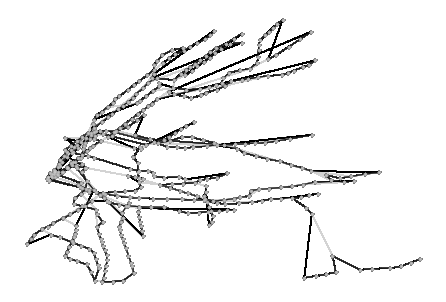

In [103]:
## special thanks to code template found here: http://brooksandrew.github.io/simpleblog/articles/intro-to-graph-optimization-solving-cpp/#cpp-solution
# colors from https://learnui.design/tools/data-color-picker.html
# visit_colors = {1:"#003f5c", 2:"#58508d", 3:"#bc5090", 4:"#ff6361", 5:"#ffa600"}
# edge_counter = {}
# g_i_edge_colors = []
for i, e in enumerate(new_h11[:-2]):
    edge = frozenset([e, new_h11[i+1]])
#     if edge in edge_counter:
#         edge_counter[edge] += 1
#     else:
#         edge_counter[edge] = 1
    # Full graph (faded in background)
    nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='gray', alpha=0.4)

    # Edges walked as of iteration i
    new_h11_x = copy.deepcopy(new_h11[0:i+2])
    g_x = nx.Graph()
    for x in range(i+1):
        edge_x = frozenset([new_h11_x[x], new_h11_x[x+1]])
        g_x.add_edge(new_h11_x[x], new_h11_x[x+1])
#         euler_circuit_i[i][2]['visits_i'] = edge_counter[edge_i]
#     g_i = nx.Graph(euler_circuit_i)
#     g_i_edge_colors = [visit_colors[e[2]['visits_i']] for e in g_i.edges(data=True)]

    nx.draw_networkx_nodes(g_x, pos=node_positions, node_size=6, alpha=0.6, node_color='lightgray', with_labels=False, linewidths=0.1)
    nx.draw_networkx_edges(g_x, pos=node_positions, edge_color='black', alpha=0.8)

#     plt.axis('off')
#     plt.savefig('H11_route_images_simplified/img{}.png'.format(i), dpi=120, bbox_inches='tight')
#     plt.close()

In [104]:
# gif 
def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]

    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

In [260]:
# make_circuit_video('H11_route_images/', 'H11_route_images_simplified/tsp_route_animation.gif', fps=5)
# to view this: click on file in finder and hit space bar
## compress using https://ezgif.com/optimize/ezgif-2-c87090f2fc86.gif
# to view in python, use this link https://stackoverflow.com/questions/28518072/play-animations-in-gif-with-tkinter

## More Complicated Gif

In [120]:
# graph that has all of the distances between possible edges
nyc_graph = dijkstar.Graph(undirected=True)
nyc_zipped_edges = list(zip(my_edgelist['node1'], my_edgelist['node2'], my_edgelist['distance']))
for x in nyc_zipped_edges:
    nyc_graph.add_edge(x[0], x[1], x[2])

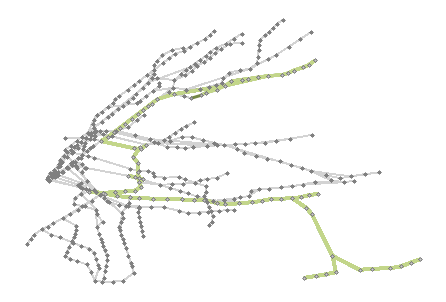

In [286]:
## special thanks to code template found here: http://brooksandrew.github.io/simpleblog/articles/intro-to-graph-optimization-solving-cpp/#cpp-solution
# colors from https://learnui.design/tools/data-color-picker.html
visit_colors = {1:'#c3d68a', 2:'#738844'}
# #                 "#2b4200", 2:"#4e6422", 3:"#738844", 4:"#9aae66", 5:"#c3d68a", 6:'#edffb0'
edge_counter = {}
new_h11_complete = [] # store all steps here
for i, e in enumerate(new_h11[:75]):
    # calculate intermediate steps
    start_node = e
    dest_node = new_h11[i+1]
    path = dijkstar.find_path(nyc_graph, start_node, dest_node)
    sorted_path = sorted(path.nodes)
    # put edges into list
    for y in range(len(sorted_path)-1):
        edge = tuple([sorted_path[y], sorted_path[y+1]])
        new_h11_complete.append(edge)

        # Edges walked as of iteration i
        edge_color_dict = {key: None for key in edge_counter.keys()}
        g_x = nx.Graph()
        for x in range(len(new_h11_complete)):
            g_x.add_edge(new_h11_complete[x][0], new_h11_complete[x][1])
        g_i_edge_colors_hex = [visit_colors[1] for x in range(len(g_x.edges)-1)]
        g_i_edge_colors_hex.append(visit_colors[2])
    # Full graph (faded in background)
        nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='gray', alpha=0.1)
        nx.draw_networkx_nodes(g_x, pos=node_positions, node_size=2, alpha=0.6, node_color='lightgray', 
                               with_labels=False, linewidths=0.1)
        nx.draw_networkx_edges(g_x, pos=node_positions, edge_color=g_i_edge_colors_hex, alpha=1,
                              width=3, connectionstyle='arc3,rad=0.2')

#     plt.axis('off')
#     plt.savefig('H11_route_images/img{}.png'.format(i), dpi=120, bbox_inches='tight')
#     plt.close()

In [276]:
make_circuit_video('H11_route_images/', 'H11_route_images/tsp_route_animation.gif', fps=8)